<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/contributed/GPIM_BEPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process-based Bayesian Opitmization in PSectroscopi Imaging: Choosing Where to Explore Polarization Dynamics in Ferroelectrics 



---


This notebook demnstrates an application of Gaussian Process-based Bayesian optimization (GP-BO) to automated sample exploration in band excitation piezoresponse spectroscopy.


---



*Notebook prepared by Kyle Kelley and Rama K. Vasudevan, November 2020*

Installations:

In [1]:
!pip install -q pycroscopy gpim 2> /dev/null

     |████████████████████████████████| 358kB 6.1MB/s 
     |████████████████████████████████| 174kB 28.1MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 788kB 24.3MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 296kB 20.8MB/s 
     |████████████████████████████████| 614kB 20.0MB/s 
     |████████████████████████████████| 481kB 31.8MB/s 
     |████████████████████████████████| 358kB 42.0MB/s 


Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyUSID as usid
import h5py
import gpim

Download data

In [4]:
!gdown https://drive.google.com/uc?id=1I3jiey6rJMSFcZhxRDPLYL6zUUKSnmq9
!gdown https://drive.google.com/uc?id=15YusfIE4dFrLaKh14DmD1KFE0ZNPDXJx
!gdown https://drive.google.com/uc?id=1kaJWmzE4CSTv-YgH9zVuzzFbAR-VDoNP

Downloading...
From: https://drive.google.com/uc?id=1I3jiey6rJMSFcZhxRDPLYL6zUUKSnmq9
To: /content/PZT_SRO_KTO_1982-7_BEVS_HighDensityGrid_15V_1um__0042.h5
1.37GB [00:26, 51.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=15YusfIE4dFrLaKh14DmD1KFE0ZNPDXJx
To: /content/idx (1).txt
100% 500/500 [00:00<00:00, 761kB/s]
Downloading...
From: https://drive.google.com/uc?id=1kaJWmzE4CSTv-YgH9zVuzzFbAR-VDoNP
To: /content/zsparse (1).txt
100% 10.2k/10.2k [00:00<00:00, 8.97MB/s]


Run the cell below to load the necessary utility functions

In [15]:
#@title Load helper functions { form-width: "10%" }
def pix_to_xy(pixind, num_cols):
  col = int(pixind % (num_cols))
  row =int(np.floor(pixind/ num_cols))
  return row, col

def xy_to_pixind(row,col,num_cols):
  return row*num_cols + col
  
def func(idx):
    """Takes a list of indices as input and returns function value at these indices"""
    return loop_areas[idx[0], idx[1]]

def usid_to_pr(h5_path, sho_fit_group = None):
    
    """This function takes as an input a h5 path to a USID file for a BEPS measurement, 
    and then returns a piezoresponse matrix along with the voltage vector for the first cycle
    Inputs:
    h5_path: string - path to the usid file containing the BEPS measurement

    Output:
    pr_array: numpy ndarray - numpy array containing the piezoresponse matrix in 3D form
    vdc_vec: numpy ndarray - numpy array containing the voltage vector

    """
    h5_f = h5py.File(h5_path, 'r')
    if sho_fit_group is None:
        
        sho_mat = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess']
        spec_val = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values']
        pos_inds = h5_f['Measurement_000/Channel_000/Position_Indices']

        steps_per_cycle = h5_f['Measurement_000'].attrs['VS_steps_per_full_cycle'] * h5_f['Measurement_000'].attrs['VS_number_of_cycles']
    else:
        sho_mat = sho_fit_group['Fit']
        spec_val = sho_fit_group['Spectroscopic_Values']
        pos_inds = sho_fit_group.parent['Position_Indices']
        
    steps_per_cycle = h5_f['Measurement_000'].attrs['VS_steps_per_full_cycle'] * h5_f['Measurement_000'].attrs['VS_number_of_cycles']
        
    pos_dim_sizes = [np.max(pos_inds[:,0])+1, np.max(pos_inds[:,1]+1)]


    #Extract the amplitude and phase from the guess or fit
    sho_mat_ndim = sho_mat[:].reshape(pos_dim_sizes[0], pos_dim_sizes[1], -1)
    amp_mat_ndim = sho_mat_ndim['Amplitude [V]']
    
    points_measured = sho_mat['Quality Factor'][:,1]!=0
    points_measured = np.where(points_measured==True)[0]
    
    phase_mat_ndim = sho_mat_ndim['Phase [rad]']
    phase_mat = sho_mat['Phase [rad]']

    #First calculate phase offset
    
    #Be careful for this: we need to exclude points that have not been measured!
    phase_mat_ndim_measured = phase_mat.copy()[points_measured,:]
    phase_offset = 0#1.75#det_phase_offset(phase_mat_ndim_measured.ravel())

    pr_mat_ndim_real = (amp_mat_ndim*np.cos(phase_mat_ndim-phase_offset))[:,:,steps_per_cycle:]
    pr_mat_ndim_imag = (amp_mat_ndim*np.sin(phase_mat_ndim-phase_offset))[:,:,steps_per_cycle:]

    vdc_vec = spec_val[0,:][steps_per_cycle:]
    
    h5_f.close()

    return [pr_mat_ndim_real, pr_mat_ndim_imag], vdc_vec, points_measured

def get_loop_areas(pr_mat_ndim_real, pr_mat_ndim_imag, vdc_vec, points_measured):

    loop_areas = np.zeros(shape=(pr_mat_ndim_real.shape[0], pr_mat_ndim_real.shape[1]))
    loop_areas[:,:,] = np.nan
    for ind, val in enumerate(points_measured):
        loop_vals_real =  pr_mat_ndim_real.reshape(-1, pr_mat_ndim_real.shape[-1])[val,:]
        loop_vals_imag =  pr_mat_ndim_imag.reshape(-1, pr_mat_ndim_imag.shape[-1])[val,:]
        
        x,y = pix_to_xy(val, pr_mat_ndim_real.shape[1])
        
        _, area_real = calculate_loop_centroid(vdc_vec[::2], loop_vals_real[::2])
        _, area_imag = calculate_loop_centroid(vdc_vec[::2], loop_vals_imag[::2])
        loop_areas[x,y] = np.sqrt(area_real**2 + area_imag**2)
    
    return loop_areas

def calculate_loop_centroid(vdc, loop_vals):
    """
    Calculates the centroid of a single given loop. Uses polyogonal centroid, 
    see wiki article for details.
    
    Parameters
    -----------
    vdc : 1D list or numpy array
        DC voltage steps
    loop_vals : 1D list or numpy array
        unfolded loop
    
    Returns
    -----------
    cent : tuple
        (x,y) coordinates of the centroid
    area : float
        geometric area
    """

    vdc = np.squeeze(np.array(vdc))
    num_steps = vdc.size

    x_vals = np.zeros(num_steps - 1)
    y_vals = np.zeros(num_steps - 1)
    area_vals = np.zeros(num_steps - 1)

    for index in range(num_steps - 1):
        x_i = vdc[index]
        x_i1 = vdc[index + 1]
        y_i = loop_vals[index]
        y_i1 = loop_vals[index + 1]

        x_vals[index] = (x_i + x_i1) * (x_i * y_i1 - x_i1 * y_i)
        y_vals[index] = (y_i + y_i1) * (x_i * y_i1 - x_i1 * y_i)
        area_vals[index] = (x_i * y_i1 - x_i1 * y_i)

    area = 0.50 * np.sum(area_vals)
    cent_x = (1.0 / (6.0 * area)) * np.sum(x_vals)
    cent_y = (1.0 / (6.0 * area)) * np.sum(y_vals)

    return (cent_x, cent_y), area


def get_mask(pr_mat_ndim, points_measured, border_px = 3):
    
    # Get row, col size
    pos_dim_sizes = (pr_mat_ndim.shape[0], pr_mat_ndim.shape[1])
    
    # create mask
    mask = np.full(shape=pos_dim_sizes, fill_value = np.nan)

    # create border
    mask[border_px:-border_px, border_px:-border_px] = 1.0
    
    # Get measured points as (x,y) list
    points_measured_xy = []
    for point in points_measured: 
        points_measured_xy.append(pix_to_xy(point, pos_dim_sizes[-1]))
    
    for (x,y) in points_measured_xy:
        mask[x,y] = np.nan
    
    return mask

Load BEPS dataset:

In [6]:
h5_f = h5py.File(r'PZT_SRO_KTO_1982-7_BEVS_HighDensityGrid_15V_1um__0042.h5', 'r+')

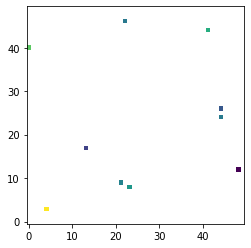

In [8]:
sho_fit_grp = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001']
pr_mat_ndim, vdc_vec, points_measured = usid_to_pr('/content/PZT_SRO_KTO_1982-7_BEVS_HighDensityGrid_15V_1um__0042.h5', sho_fit_group =sho_fit_grp )

pr_mat_ndim_guess, _, _ = usid_to_pr('/content/PZT_SRO_KTO_1982-7_BEVS_HighDensityGrid_15V_1um__0042.h5')

loop_areas = get_loop_areas(pr_mat_ndim[0][:,:,::2], pr_mat_ndim[1][:,:,::2], vdc_vec[::2], points_measured)
loop_areas_guess = get_loop_areas(pr_mat_ndim_guess[0], pr_mat_ndim_guess[1], vdc_vec, points_measured)
loop_areas = (loop_areas - np.min(loop_areas)) / (np.max(loop_areas) - np.min(loop_areas))

loop_areas_guess = (loop_areas_guess - np.min(loop_areas_guess)) / (np.max(loop_areas_guess) - np.min(loop_areas_guess))

Inspect the dataset

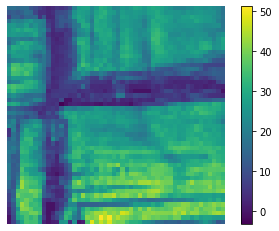

In [9]:
mat = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']
plt.figure()
plt.imshow(np.reshape(mat['Amplitude [V]'][:,0]*np.cos(mat['Phase [rad]'][:,0]+0.25)*1E5,(50,50)), origin= 'bottom')
plt.axis('off')
plt.colorbar()

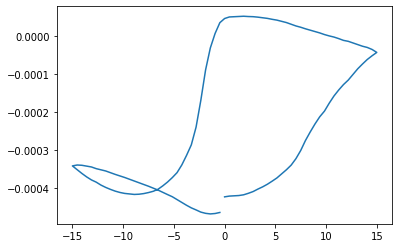

In [10]:
pr_mater = mat['Amplitude [V]'][:,1::2]*np.cos(mat['Phase [rad]'][:,1::2]+0.25)
pr_mater_avg = np.mean(pr_mater,axis = 0)

plt.figure()
plt.plot(vdc_vec[::2],-1*pr_mater_avg[128:256])

Plot calculated loop areas:

(-0.5, 49.5, -0.5, 49.5)

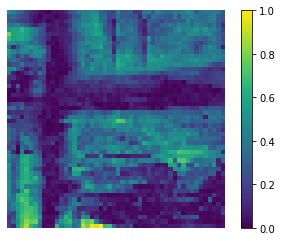

In [12]:
plt.figure()
plt.imshow((loop_areas),origin = 'bottom')
plt.colorbar()
plt.axis('off')

Generate initial seed points:

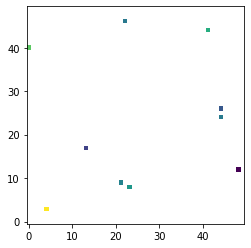

In [13]:
# Load seed points
idx = np.loadtxt('idx (1).txt')
Z_sparse = np.loadtxt('zsparse (1).txt')

plt.imshow(Z_sparse, origin='bottom')

points_measured = [xy_to_pixind(x,y, num_cols=50) for (x,y) in idx]
mask = get_mask(Z_sparse, points_measured)

Run GP-BO:

In [16]:
# Get full and sparse grids
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)
# Initialize Bayesian optimizer with a custom acquisition function
boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    func, acquisition_function='ei',
    # alpha=1, beta=2, # for confidence bound acquisition function
    exploration_steps=401, 
    dscale= 10.,
    exit_strategy = 1,
    mask = mask,
    kernel = 'RBF',
    batch_size=500,
    gp_iterations=300,
    lengthscale = [.5, 2.],
    use_gpu=True,
    verbose=1)
# Run Bayesian optimization
boptim.run()


Exploration step 1 / 401
Model training...
average time per iteration: 0.0096 s
training completed in 2.51 s
Final parameter values:
 amp: 0.1472, lengthscale: 1.9935, noise: 0.0018801
Computing acquisition function...
Model training...
average time per iteration: 0.0078000000000000005 s
training completed in 2.29 s
Final parameter values:
 amp: 0.1364, lengthscale: 1.9999, noise: 2.98e-05

Exploration step 2 / 401
Computing acquisition function...
Model training...
average time per iteration: 0.0076 s
training completed in 2.28 s
Final parameter values:
 amp: 0.1325, lengthscale: 2.0, noise: 5e-07

Exploration step 3 / 401
Computing acquisition function...
Model training...
average time per iteration: 0.0077 s
training completed in 2.25 s
Final parameter values:
 amp: 0.1228, lengthscale: 2.0, noise: 0.0

Exploration step 4 / 401
Computing acquisition function...
Model training...
average time per iteration: 0.008 s
training completed in 2.36 s
Final parameter values:
 amp: 0.1148, l

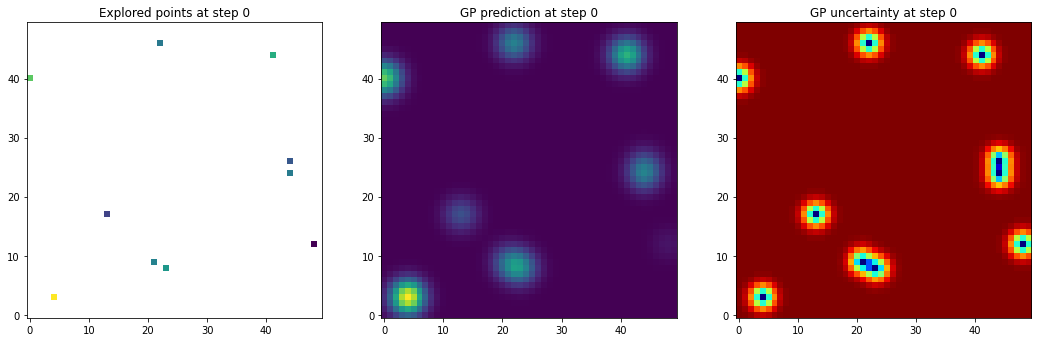

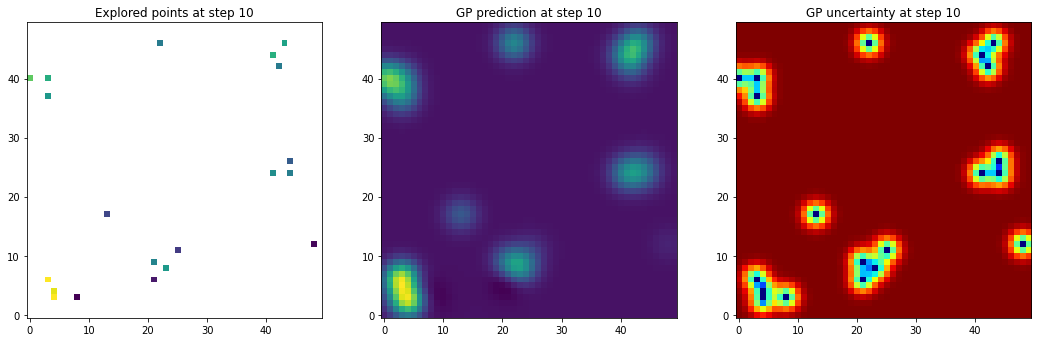

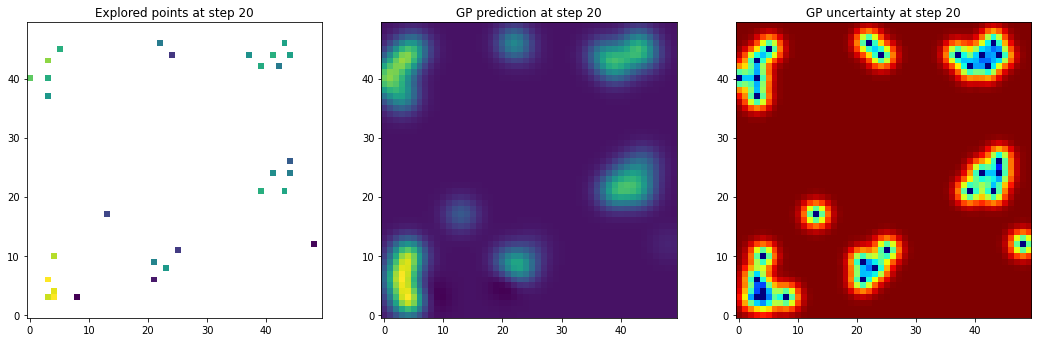

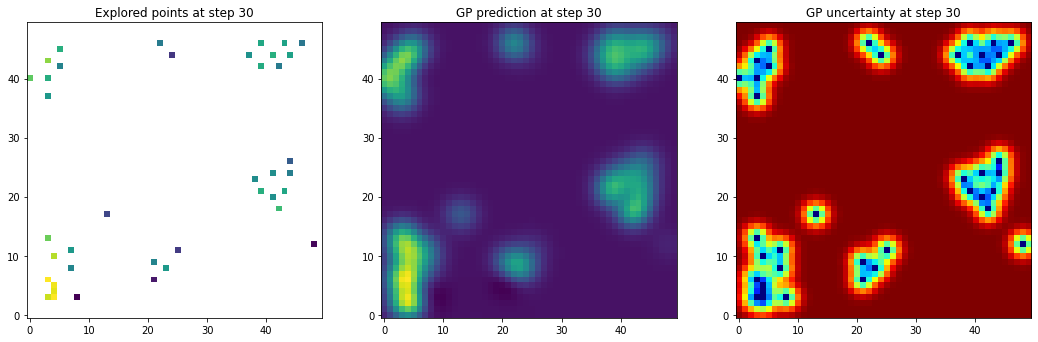

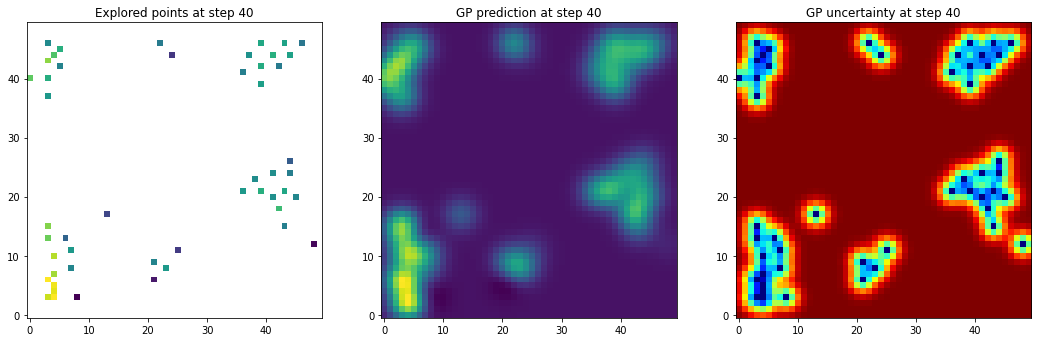

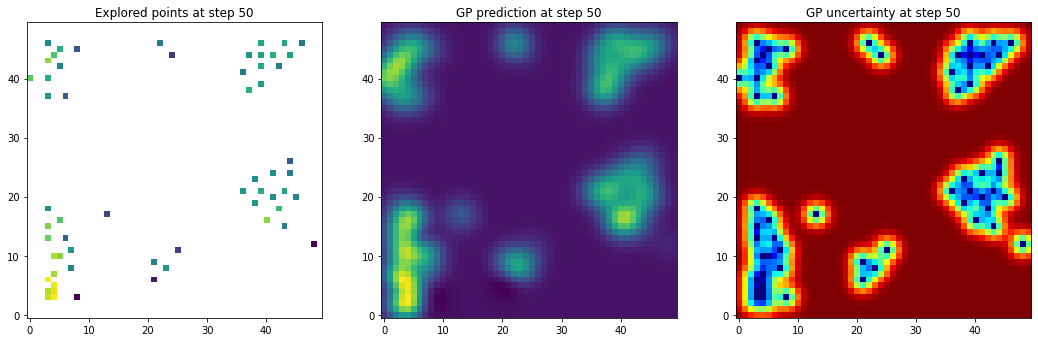

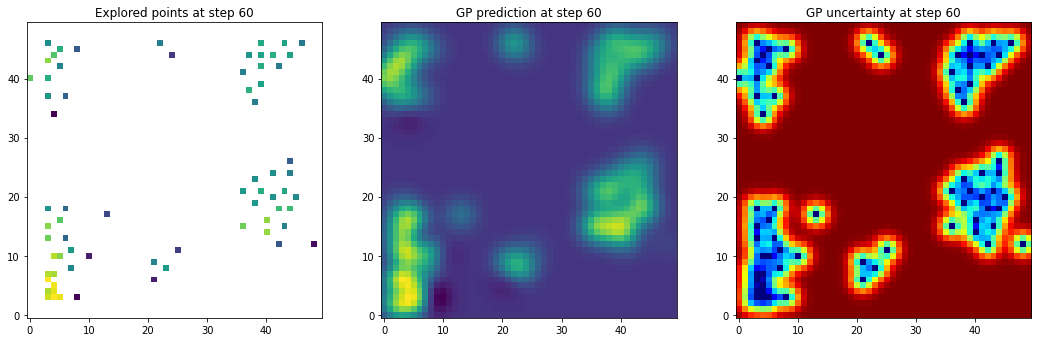

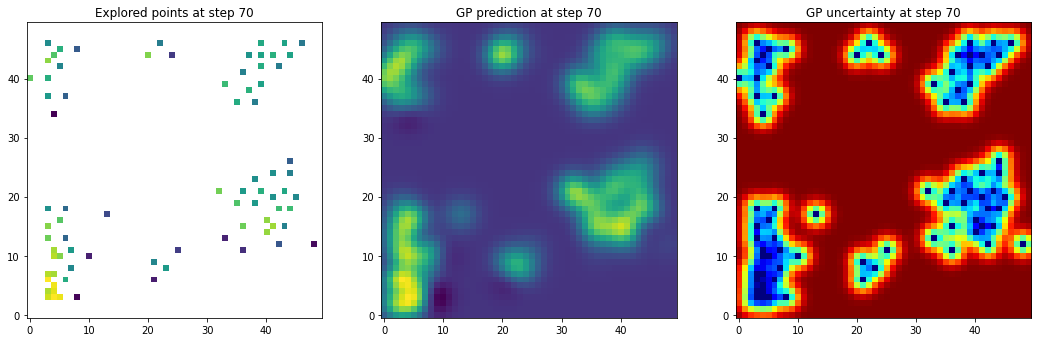

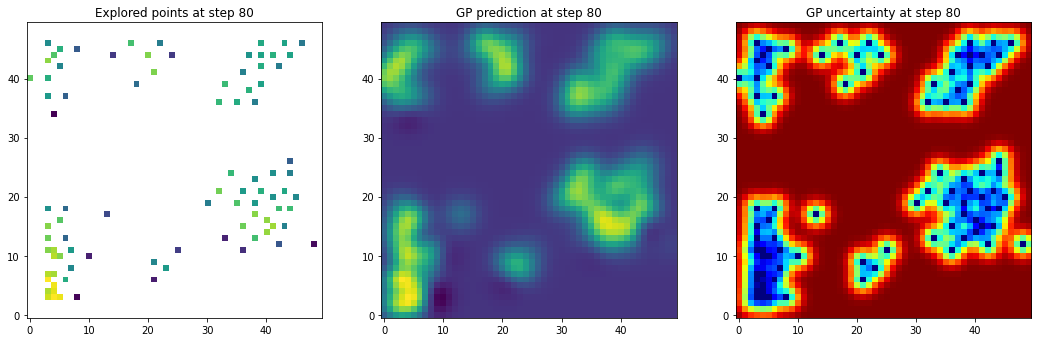

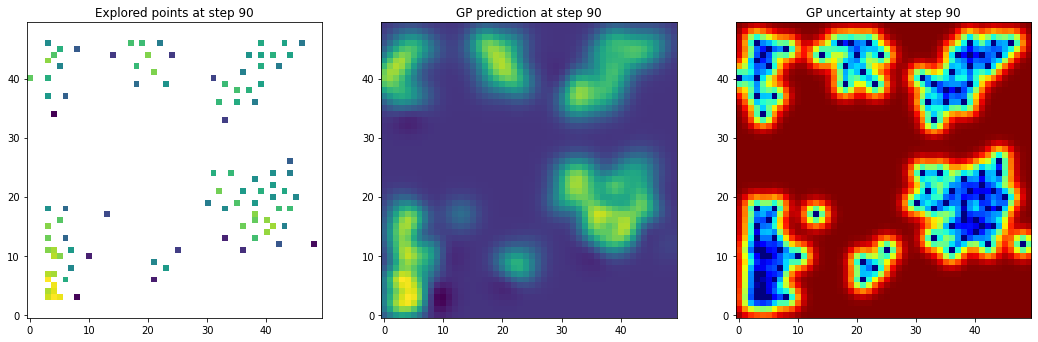

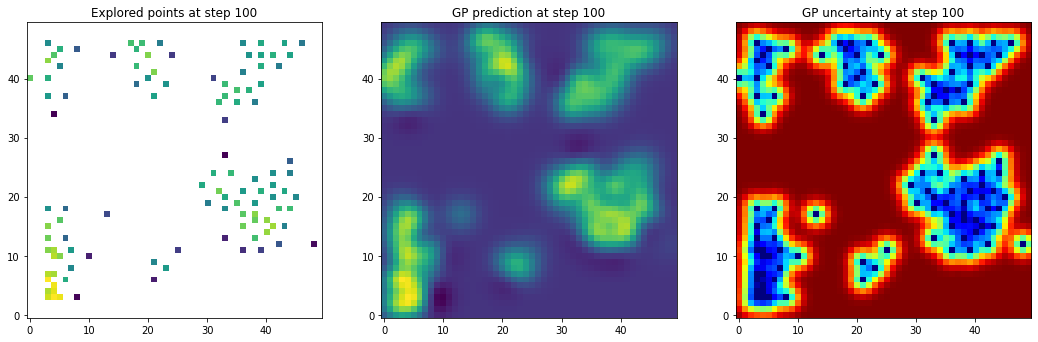

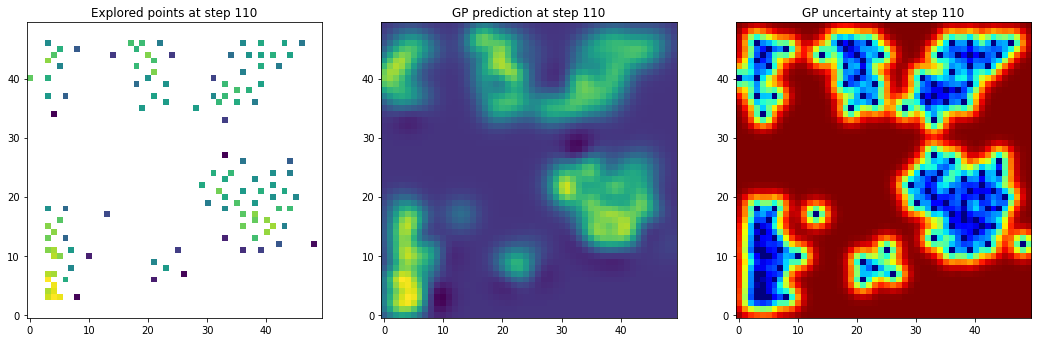

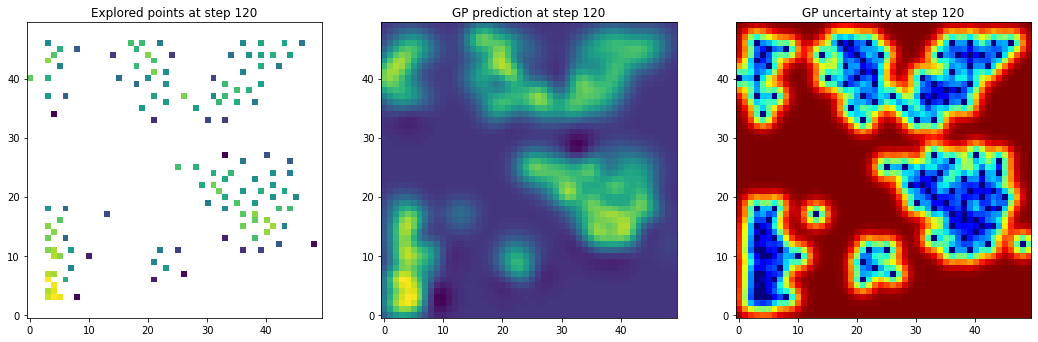

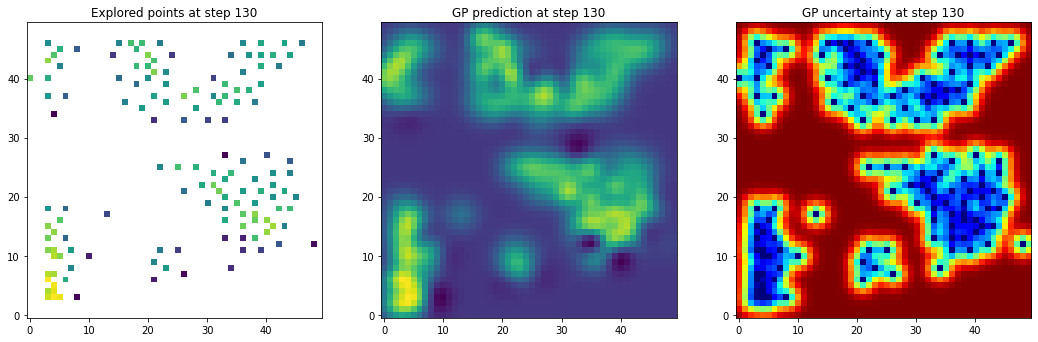

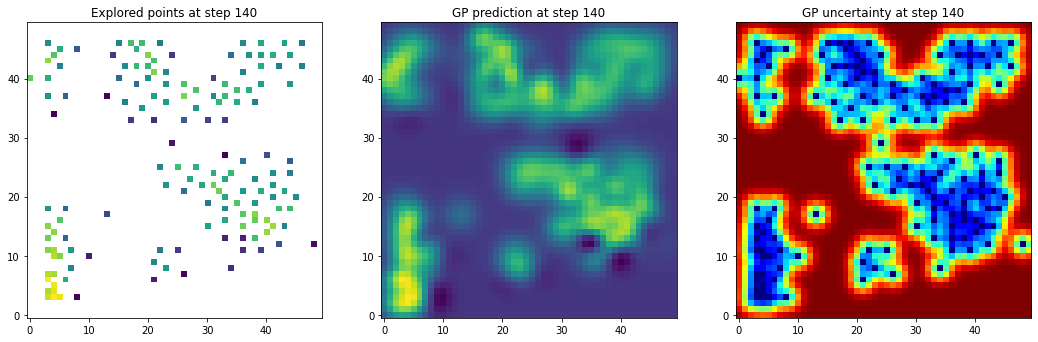

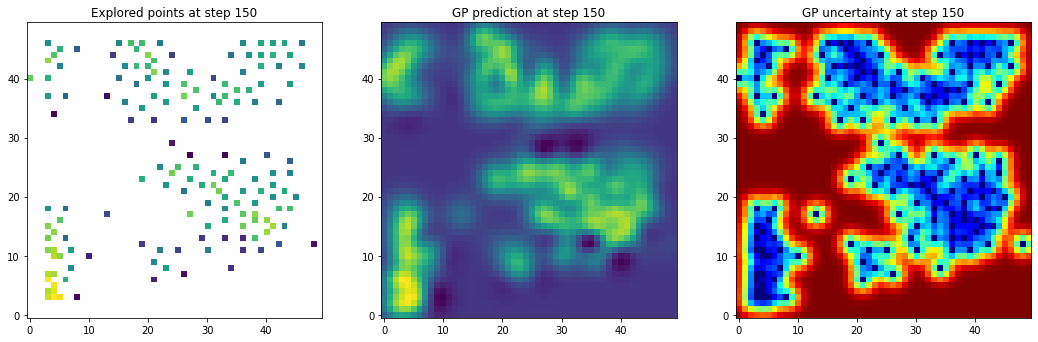

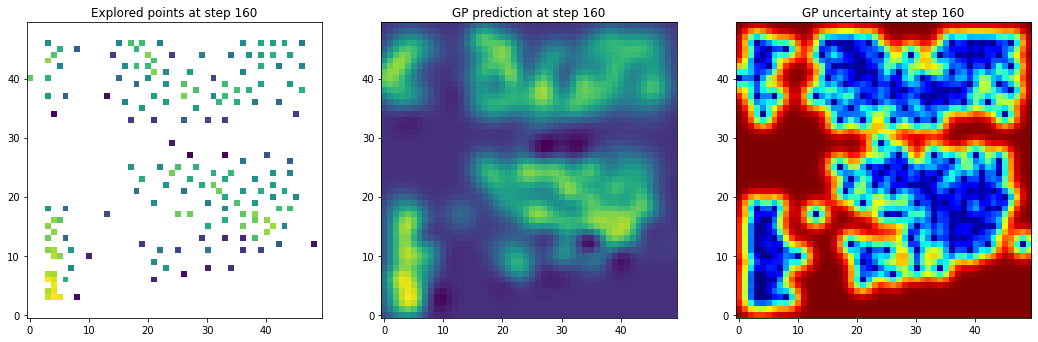

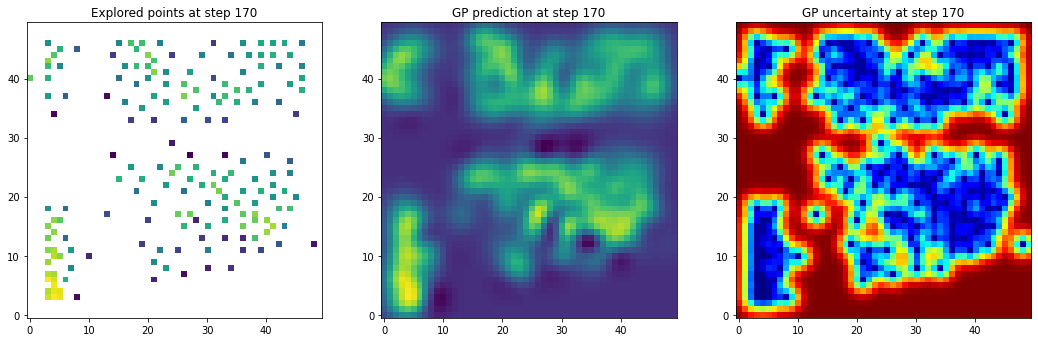

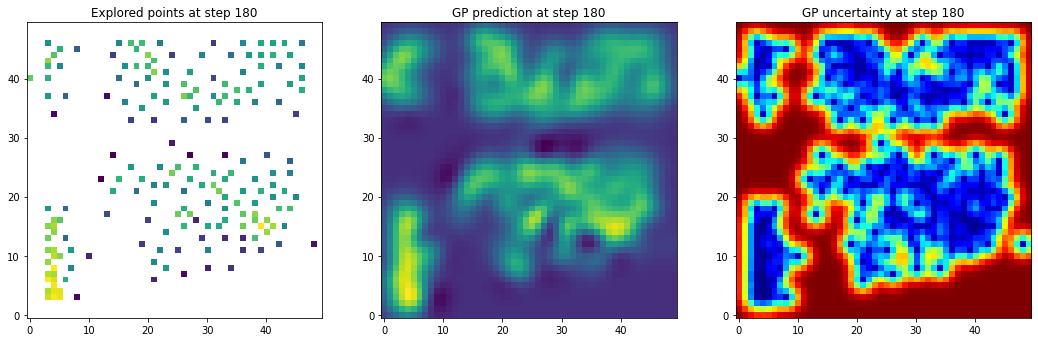

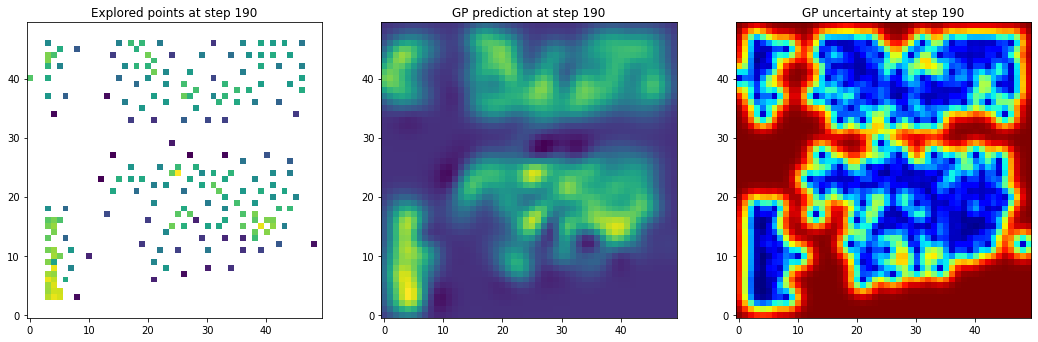

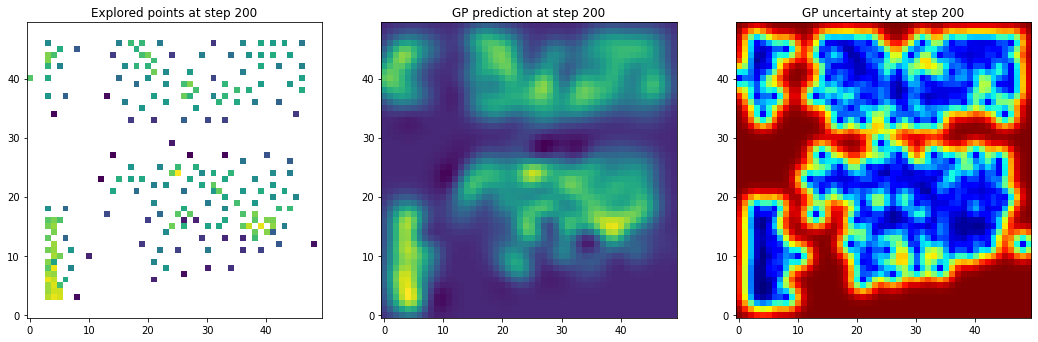

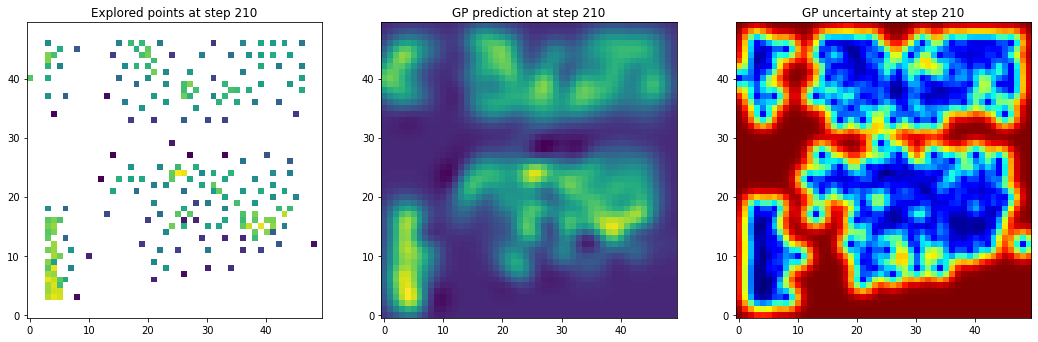

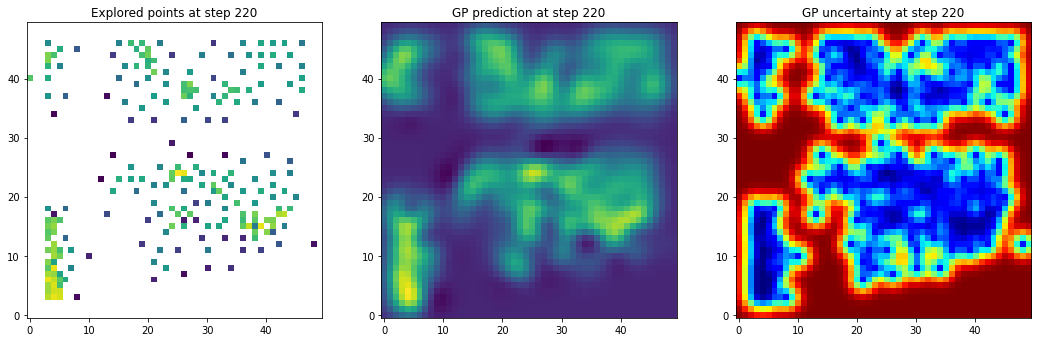

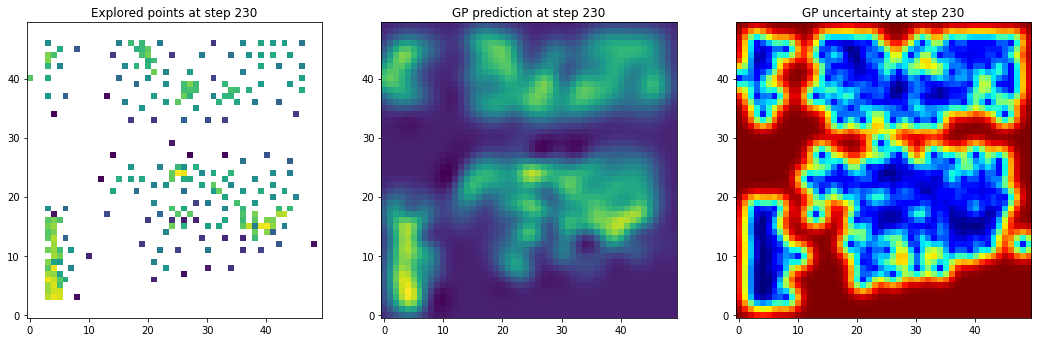

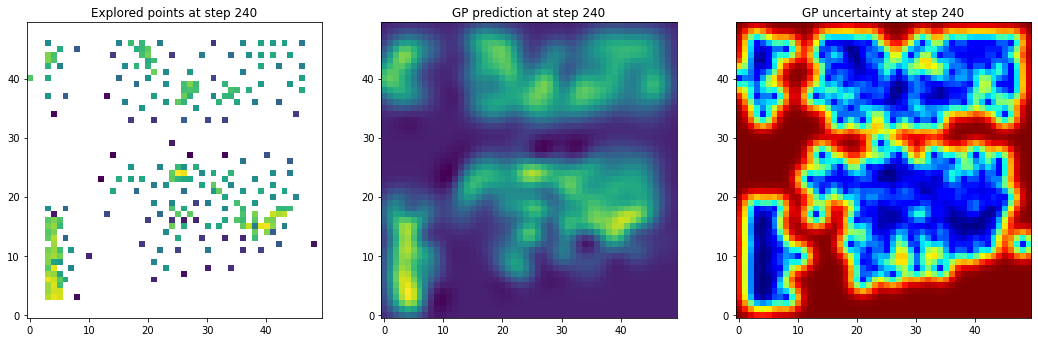

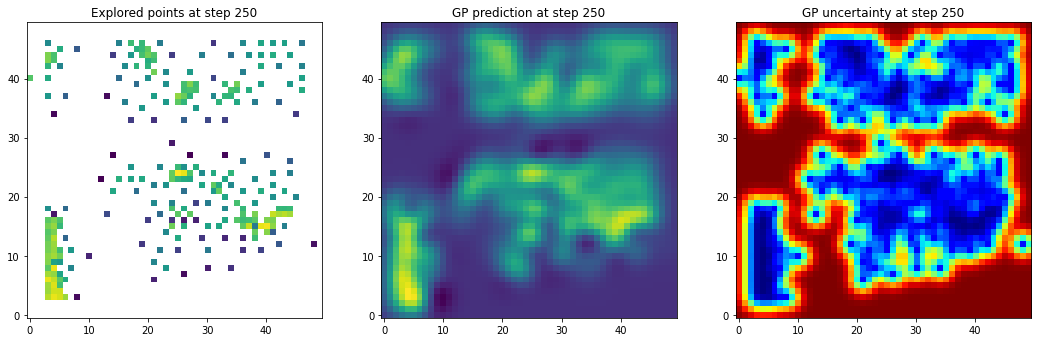

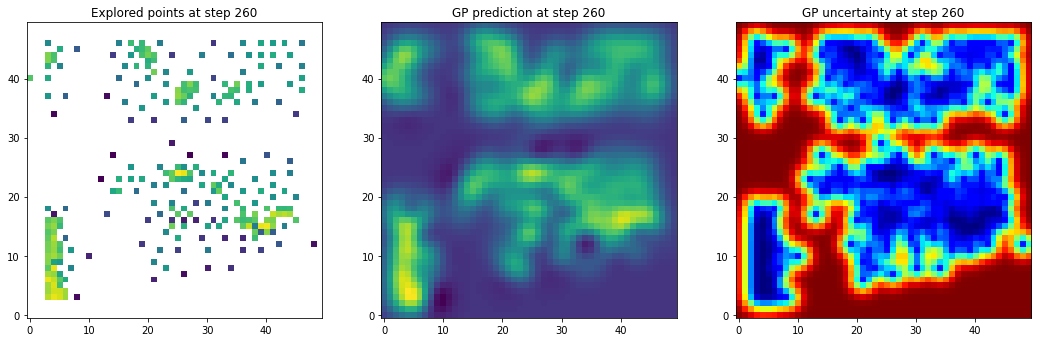

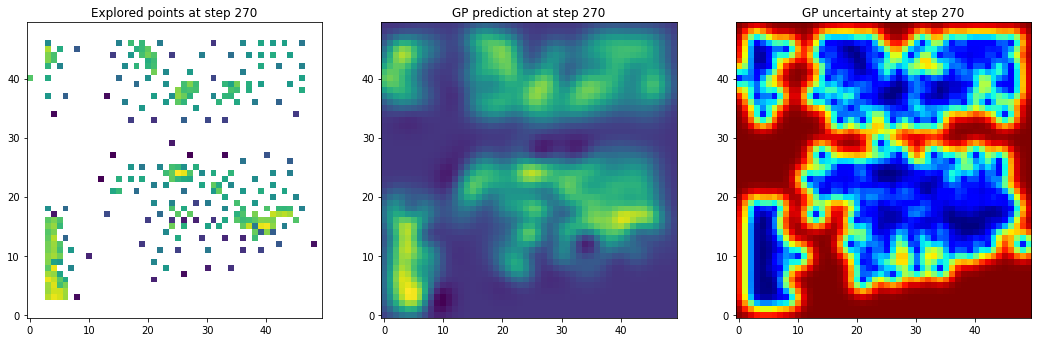

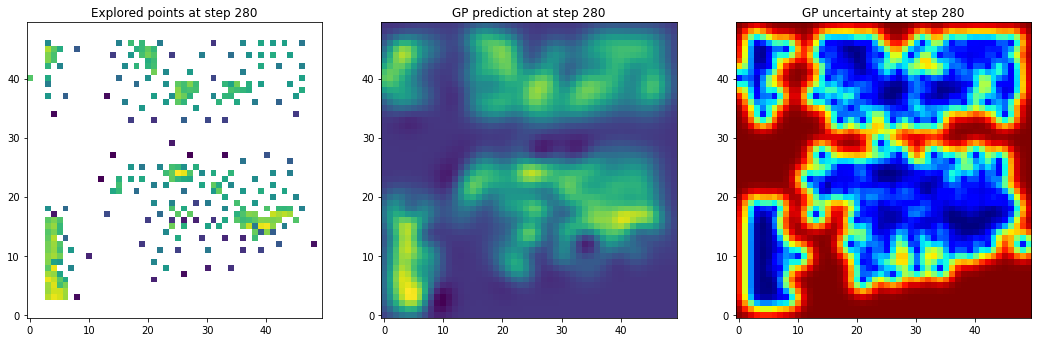

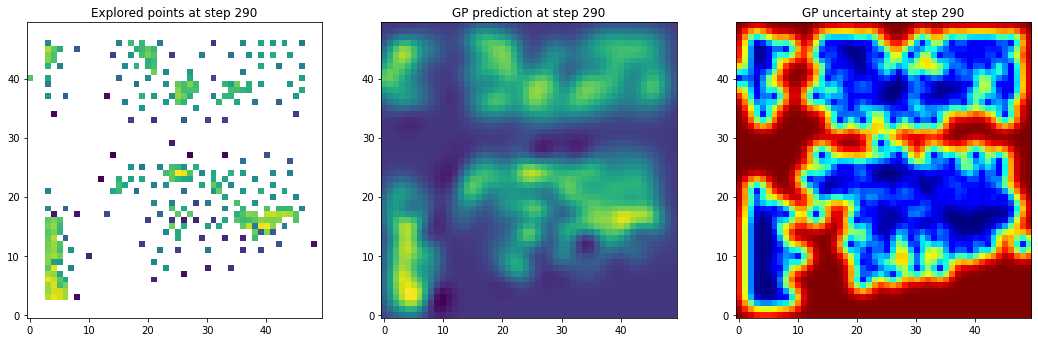

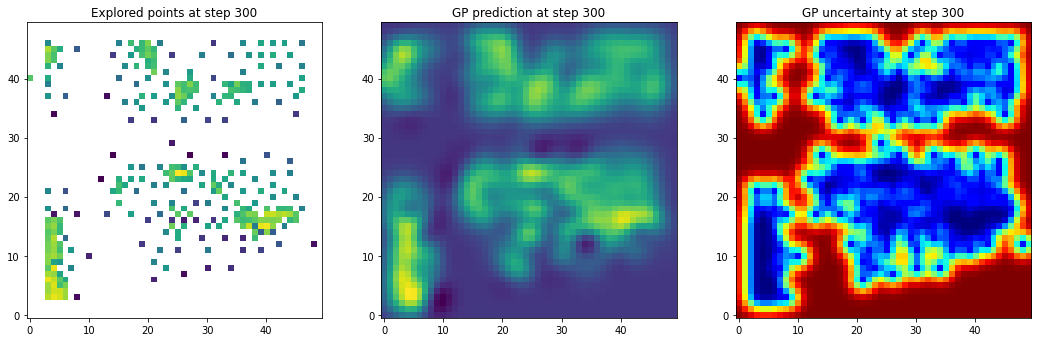

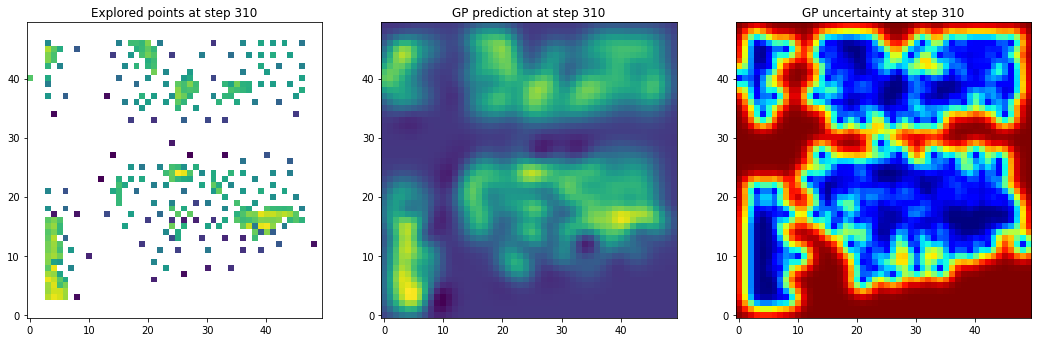

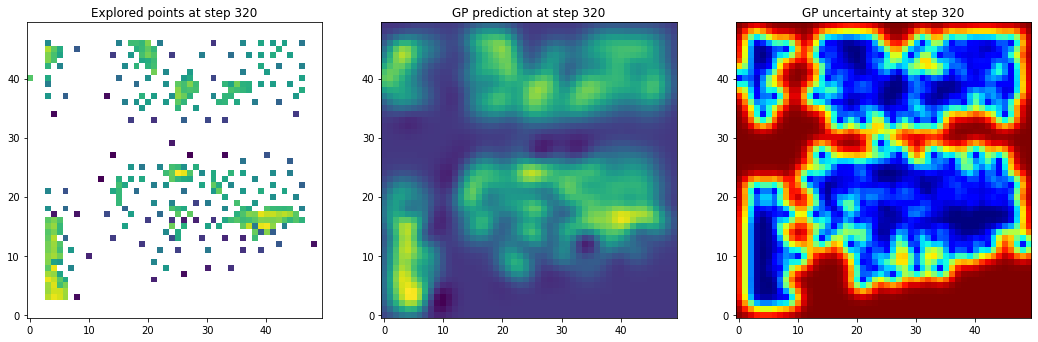

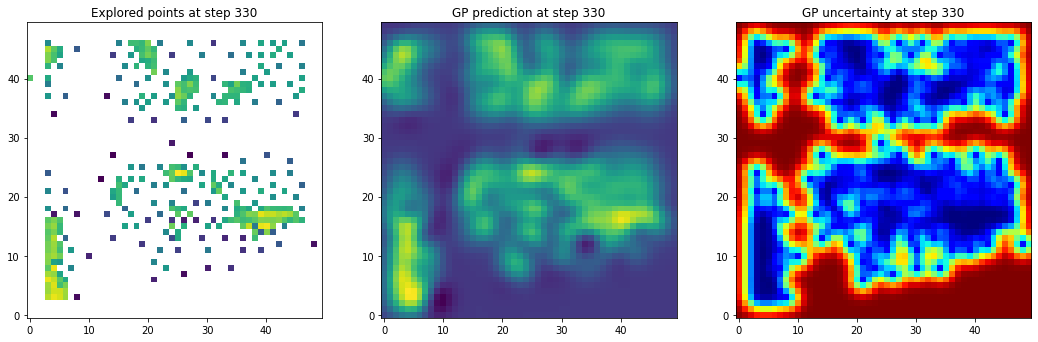

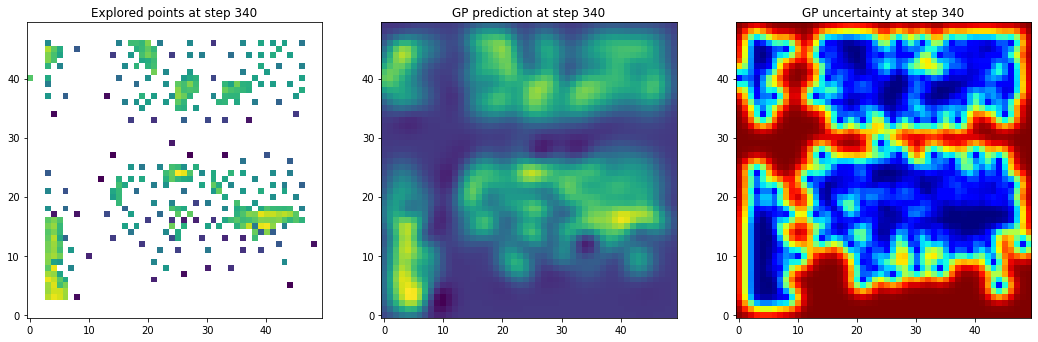

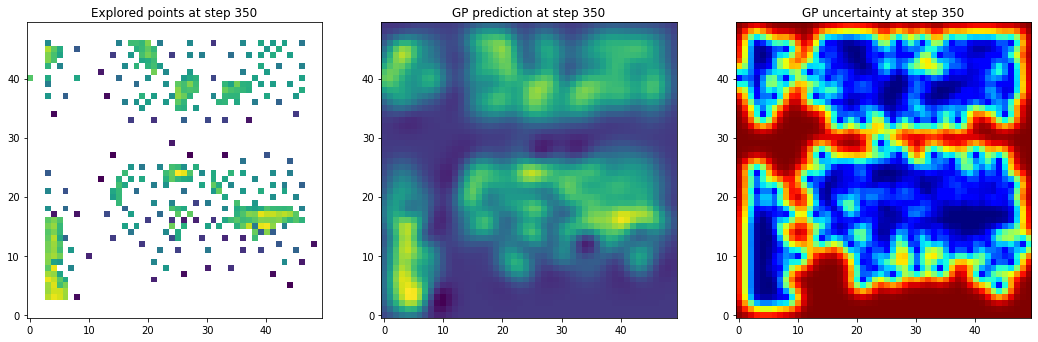

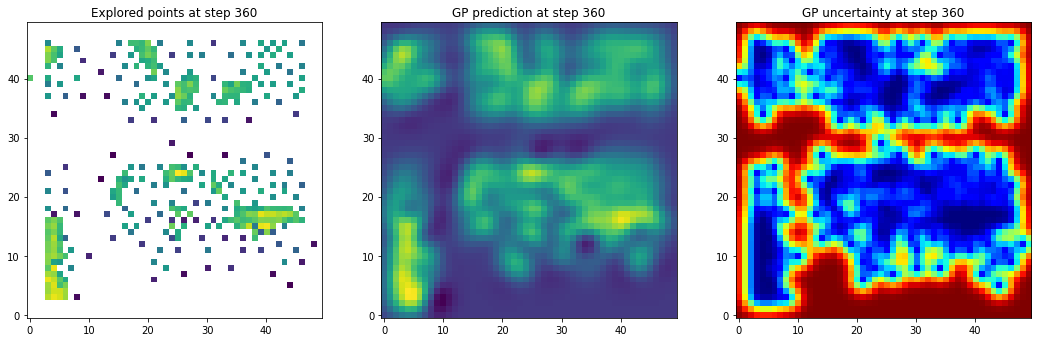

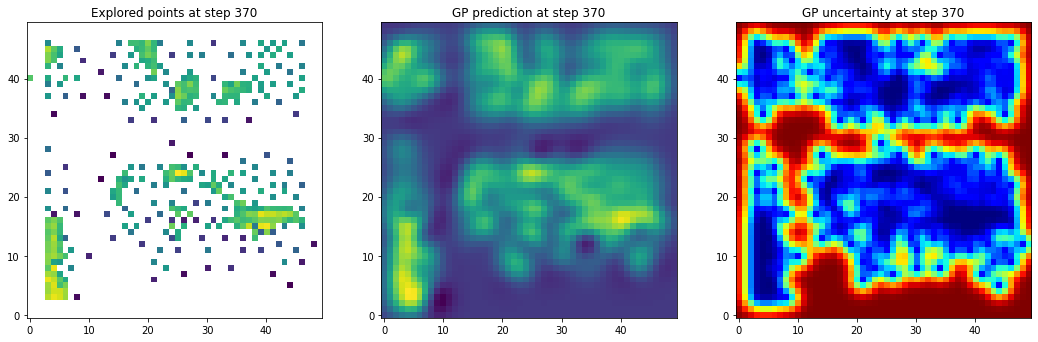

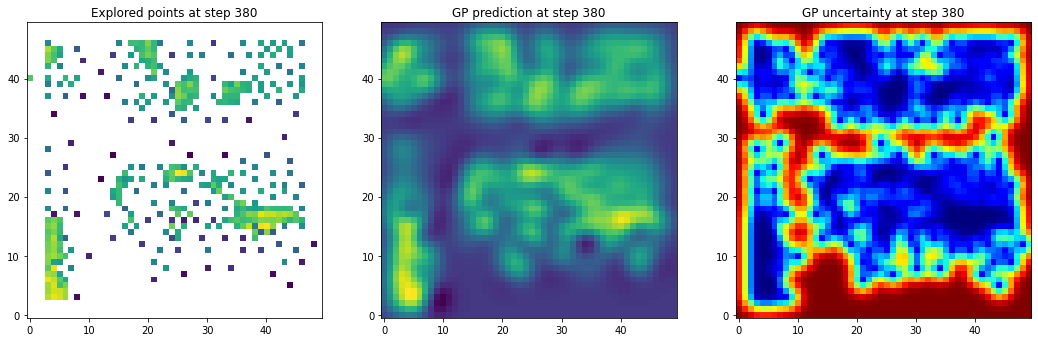

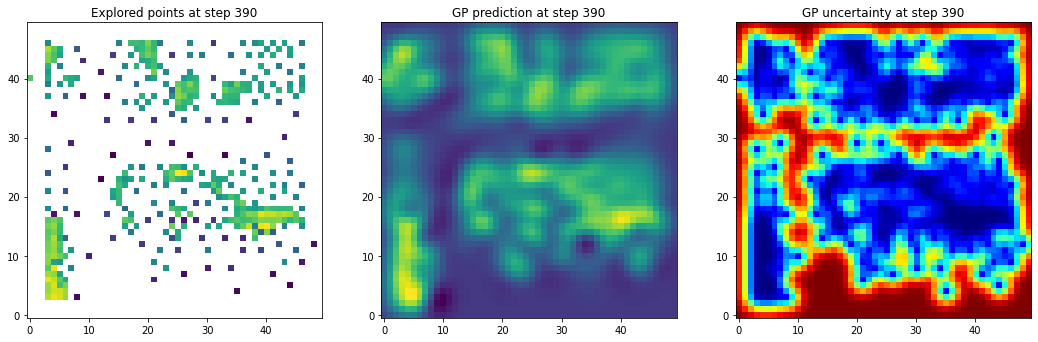

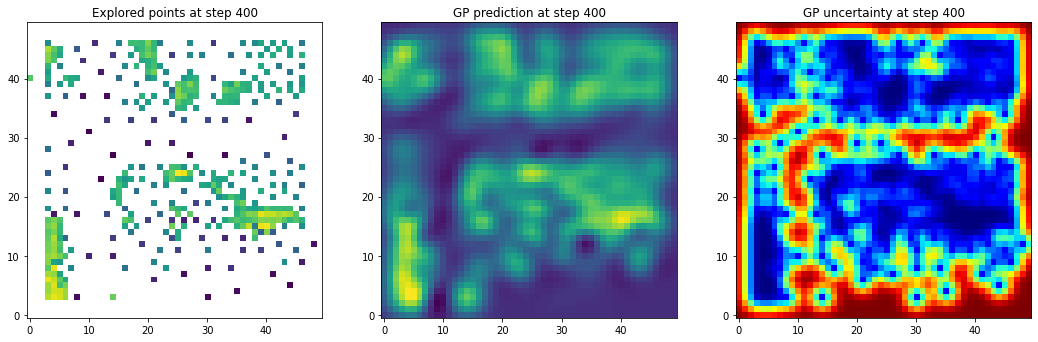

In [19]:
 func_val, gp_pred = boptim.target_func_vals, boptim.gp_predictions
 vals_all = np.array(boptim.vals_all)
 inds_all = np.array(boptim.indices_all)
 for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
   if i % 10 == 0:
     _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
     ax1.imshow(func, origin='bottom', cmap='viridis')
     ax2.imshow(pred[0], origin='bottom', cmap = "viridis")
     ax3.imshow(pred[1], origin='bottom', cmap='jet')
     ax1.set_title('Explored points at step {}'.format(i))
     ax2.set_title('GP prediction at step {}'.format(i))
     ax3.set_title('GP uncertainty at step {}'.format(i))
     plt.show()